#### クラス編成
- 課題整理(条件)
  - 全生徒を1つのクラスに割り当てる
  - クラス人数は39人以上40人以下
  - 男子生徒、女子生徒は20人以下
  - 学力試験のクラス平均点は学年平均の±10点
  - リーダ気質の生徒を2人以上
  - 特別支援生徒は1人以下
  - 特定ペアの生徒は別クラスとする

- List
  - $S$ : Students list
  - $C$ : Class list
  - $S_{male}$ : Men list
  - $S_{female}$ : Women list
  - $S_{leader}$ : leaders list
  - $S_{support}$ : supports list
  - $S_{specific}$ : Specific Pairs list
- Variable
  - $x_{s,c} \in \{0, 1\} (s\in S, c\in C)$
- Constant
  - $score_s$ : Score of students
  - $score_{mean}$ : Score of mean
- Constraints
  1. $\sum_{c\in C} x_{s,c} = 1 \quad (s \in S)$
  2. $\sum_{s\in S} x_{s,c} \ge 39 \quad (c \in C), \quad \sum_{s\in S} x_{s,c} \le 40 \quad (c \in C)$
  3. $\sum_{s\in S_{male}} x_{s,c} \le 20 \quad (c \in C), \quad \sum_{s\in S_{female}} x_{s,c} \le 20 \quad (c \in C)$
  4. $\sum_{S_{leader}}x_{s,c} \le 2$
  5. $\sum_{S_{support}}x_{s,c} \le 1$
  6. $(score_{mean}-10) \cdot \sum_{s\in S} x_{s,c} \ge \sum_{s\in S} score_s \cdot x_{s,c}, \quad \sum_{s\in S} score_s \cdot x_{s,c} \le (score_{mean}+10) \cdot \sum_{s\in S} x_{s,c}$
  7. $x_{s1,c} + x_{s2,c} \le 1$
- Objective
  - None(Maximize)

In [1]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import math
from itertools import product

In [2]:
glob('../*/*school/*.csv')
students_df = pd.read_csv(glob('../*/*school/students.csv')[0])
student_pairs_df = pd.read_csv(glob('../*/*school/student_pairs.csv')[0])

In [3]:
students_df.head(3)

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350


In [4]:
students_df['student_id'].nunique()

318

In [5]:
students_df['gender'].value_counts()

gender
0    160
1    158
Name: count, dtype: int64

In [6]:
students_df['leader_flag'].value_counts()

leader_flag
0    301
1     17
Name: count, dtype: int64

In [7]:
students_df['support_flag'].value_counts()

support_flag
0    314
1      4
Name: count, dtype: int64

In [8]:
students_df['score'].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<Axes: >

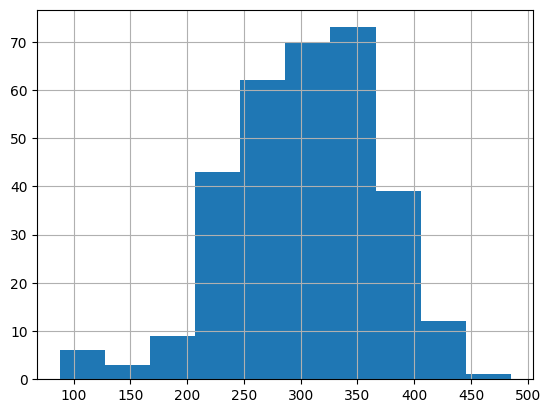

In [9]:
students_df['score'].hist()

In [10]:
student_pairs_df.head()

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


条件をデータフレームに整理

In [11]:
class_structure = np.zeros((318, 8))
df = pd.DataFrame(
    class_structure,
    index=[f'ID {i+1:03}' for i in range(318)],
    columns=[chr(i+65) for i in range(8)],
    )
df['score'] = students_df['score'].to_list()
df['total'] = 1
display(df.head(5))


conditon_df = pd.DataFrame([40, 39, 20, 20, 2, 1, 1, students_df['score'].mean()+10, students_df['score'].mean()-10, ])
conditon_df.columns = ['Conditon']
conditon_df.index = ['max', 'min', 'men_max', 'women_max', 'leader_min', 'supprot_max', 's1+s2_max', 'score_max', 'score_max']
conditon_df.T

,A,B,C,D,E,F,G,H,score,total
ID 001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,335,1
ID 002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,379,1
ID 003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350,1
ID 004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,1
ID 005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,317,1


,max,min,men_max,women_max,leader_min,supprot_max,s1+s2_max,score_max,score_max
Conditon,40.0,39.0,20.0,20.0,2.0,1.0,1.0,313.644654,293.644654


数理モデル定義

In [12]:
prob = LpProblem('ClassAssignmentProblem', LpMaximize)

変数定義

In [13]:
S = students_df['student_id'].to_list()
class_num = math.ceil(students_df['student_id'].count()/40)
C = [chr(i+65) for i in range(class_num)]
SC = list(product(S, C))

x = LpVariable.dicts('x', SC, cat='Binary')
for i in range(3):
    print(x[i+1, 'A'])
print('.'*10)

x_(1,_'A')
x_(2,_'A')
x_(3,_'A')
..........


In [14]:
S = students_df['student_id'].to_list()
class_num = math.ceil(students_df['student_id'].count()/40)
C = [chr(i+65) for i in range(class_num)]
SC = [(s, c) for s in S for c in C]
SC = product(S, C)

x = LpVariable.dicts('x', SC, cat='Binary')

条件定義

In [15]:
# 男女別 ID 
S_men = students_df['student_id'][students_df['gender'] == 1]
S_women = students_df['student_id'][students_df['gender'] == 0]
# リーダー ID 
S_leader = students_df['student_id'][students_df['leader_flag'] == 1]
# サポート ID 
S_support = students_df['student_id'][students_df['support_flag'] == 1]
# 平均値と得点リスト
score_mean = students_df['score'].mean()
score = students_df.set_index('student_id').to_dict()['score']

In [16]:
# 行の合計を 1 にする
for s in S:
    prob += lpSum([x[s, c] for c in C]) == 1

In [17]:
for c in C:
    # 列の合計を 39以上、40以下にする
    prob += lpSum([x[s, c] for s in S]) >= 39
    prob += lpSum([x[s, c] for s in S]) <= 40

    # 列の合計で男女それぞれ20以下とする
    prob += lpSum([x[s, c] for s in S_men]) <= 20
    prob += lpSum([x[s, c] for s in S_women]) <= 20

    # 列合計でリーダ計を 2 以上とする
    prob += lpSum([x[s, c] for s in S_leader]) >= 2

    # 列合計でサポート計を 1 以下とする
    prob += lpSum([x[s, c] for s in S_support]) <= 1

    # 平均点差 ±10点
    prob += (score_mean - 10) * lpSum([x[s, c] for s in S]) <= lpSum([x[s, c]*score[s] for s in S])
    prob += (score_mean + 10) * lpSum([x[s, c] for s in S]) >= lpSum([x[s, c]*score[s] for s in S])

In [18]:
# 列合計で特定ペア計が 1 以下とする
SS = [(r.student_id1, r.student_id2) for r in student_pairs_df.itertuples()]
for s1, s2, in SS:
    for c in C:
        prob += x[s1, c] + x[s2, c] <= 1

求解と結果表示

In [19]:
status = prob.solve()
print(status)
print('Status:', LpStatus[status])

C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s, c].value() == 1]
    
for c, Ss in C2Ss.items():
    print(f'Class: {c}')
    print(f'Num: {len(Ss)}')
    print(f'Students: {Ss}')
    print()

1
Status: Optimal
Class: A
Num: 40
Students: [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 101, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298]

Class: B
Num: 40
Students: [11, 15, 43, 48, 50, 70, 82, 89, 91, 102, 104, 114, 120, 121, 124, 127, 134, 146, 149, 159, 167, 170, 172, 176, 190, 203, 213, 220, 222, 231, 238, 245, 263, 270, 275, 276, 283, 287, 290, 317]

Class: C
Num: 40
Students: [3, 10, 14, 23, 27, 31, 41, 49, 53, 54, 58, 73, 93, 94, 97, 98, 113, 122, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 235, 236, 242, 254, 258, 260, 268, 273, 277, 278, 301, 318]

Class: D
Num: 40
Students: [13, 16, 33, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 92, 107, 108, 128, 139, 140, 144, 158, 161, 175, 183, 192, 198, 200, 205, 221, 225, 241, 252, 255, 256, 257, 261, 266, 284, 293, 316]

Class: E
Num: 39
Students: [4, 5, 21, 24, 38, 62, 69, 72, 78, 87, 96, 105, 106, 115, 132, 141, 143, 150, 154, 164, 166, 1